In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
from openpyxl import load_workbook
#from shapely.geometry import Point, LineString
#import shapely, shapely.prepared

In [185]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
brown2 = '#B45419'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
teal1 = '#294839'
green1 = '#6DA08C'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#7A693B'
beige2 = '#A89677'
beige3 = '#D2CDAD'
grey1 = '#E7E7E7'
grey2 = '#D7D7D7'
grey3 = '#C6C6C6'
grey4 = '#939393'
blue1 = '#3EA1C0'

In [186]:
discountrate = 0.04
NoOfPeakSeason = 2
lengthPeakSeason = 24 # Usually 24
NoOfRegSeason = 4
lengthRegSeason = 168
LeapYearsInvestment = 5
fix_sample = 'random' # fix_sample = True --> 'no', fix_sample = False = 'random'
season_scale = [(8760 - NoOfPeakSeason * lengthPeakSeason) / NoOfRegSeason / lengthRegSeason
                            for x in range(NoOfRegSeason)] + [1 for x in range(NoOfPeakSeason)]
new_names = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro ror', 'Hydro storage', 'Geothermal']
new_names_2 = ['CCGT',   'OCGT',  'Biomass',  'Oil'  ,'Wind', 'Solar', 'Hydro', 'Geothermal']
old_names = ['Gas CCGT',    'Gas OCGT',  'Bio',   'Oil existing',  'Wind onshore',  'Solar'  ,'Hydro run-of-the-river', 'Hydro regulated', 'Geo']
scenario = '10'
date = '052
6'
time = '2224_bnze2060'



file_path = 'Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time + '/results_output_EuropePlot.csv'
operational_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_Operational.csv')
investment_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_gen.csv')
objective_value = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_objective.csv', header=None)
transmission_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_transmision.csv')
stor_data = pd.read_csv('Results/bolivia_v1_reg' + str(lengthRegSeason) + '_peak' + str(lengthPeakSeason) + '_sce' + scenario + '_' + fix_sample + 'SGR_2024' + date + time +'/results_output_stor.csv')
node_sheet = load_workbook('Data handler/bolivia_v1/Node.xlsx')

scenario_int = int(scenario)
prob_scenarios = {f"scenario{i}": 1/scenario_int for i in range(1,scenario_int+1)}
regular_seasons = ['winter', 'spring', 'summer', 'fall']
peak_seasons = ['peak1', 'peak2']
periods = ['2025-2030', '2030-2035', '2035-2040', '2040-2045', '2045-2050', '2050-2055', '2055-2060']
start_year = 2025

new_run = True

In [187]:
# Helper functions
def get_colors(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, teal2, brown2]
    color_dict = dict(zip(new_names_2, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def get_colors1(carriers):
    colors = [beige2, beige3, teal3, beige1, teal4, yellow, blue1, teal2, brown2]
    color_dict = dict(zip(new_names, colors))
    colors_new = [color_dict[carrier] for carrier in carriers]
    return colors_new

def rename_columns(df):
    old_names_no_space = [names.replace(" ", "") for names in old_names]
    name_map= dict(zip(old_names_no_space, new_names))
    df = df.rename(columns=name_map)
    return df

def open_csv(file, included_rows):
    data_list = []
    with open(file, 'r') as f:
        next(f)
        headers = f.readline().strip().split(',')  # Read the first line to get headers
        for i, line in enumerate(f, start=2):  # Start counting from 2 since headers are at line 1
            if i in included_rows:
                # Split the line by comma, or change delimiter as necessary
                values = line.strip().split(',')
                # Create a dictionary for the row using a dictionary comprehension and zip to pair headers and values
                row_data = dict(zip(headers, values))
                data_list.append(row_data)
    return pd.DataFrame(data_list)

def rename_columns_operations(df):
    operations_names = ['GasCCGT_MW', 'GasOCGT_MW', 'Bio_MW', 'Oilexisting_MW', 'Windonshore_MW', 'Solar_MW', 'Hydrorun-of-the-river_MW', 'Hydroregulated_MW', 'Geo_MW']
    name_map= dict(zip(operations_names, new_names))
    df = df.rename(columns=name_map)
    return df

def custom_autopct(pct):
    return ('%1.1f%%' % pct)# if pct > 0 else ''

def get_marginal_cost(technology, period):
    generator_file = load_workbook('Data handler/bolivia_v1/Generator.xlsx')
    generator_efficiency = generator_file['Efficiency']
    generator_VOM = generator_file['VariableOMCosts']
    generator_fuel_cost = generator_file['FuelCosts']
 
    for row in range(2, generator_efficiency.max_row + 1):  
        if generator_efficiency.cell(row, 1).value == technology and generator_efficiency.cell(row, 2).value == period:
            efficiency = generator_efficiency.cell(row, 3).value  
            break  
 
    for row in range(2, generator_VOM.max_row + 1):
        if generator_VOM.cell(row, 1).value == technology:
            VOM = generator_VOM.cell(row, 2).value
            break
 
    for row in range(2, generator_fuel_cost.max_row + 1):
        if generator_fuel_cost.cell(row, 1).value == technology and generator_fuel_cost.cell(row, 2).value == period:
            fuel_cost = generator_fuel_cost.cell(row, 3).value
            break
 
    marginal_cost = (3.6 / efficiency) * fuel_cost + VOM
    return marginal_cost

# Original decom dictionary

decom = {
    2025: {'BO0 1': ['OCGT', 16.84]},
    2026: {'BO0 5': ['OCGT', 49.76 + 51.37]},
    2027: {'BO0 1': ['OCGT', 15.99]},
    2028: {},
    2029: {'BO0 1': ['OCGT', 57.14 + 55.97]},
    2030: {'BO0 1': ['OCGT', 18.1], 'BO0 5': ['OCGT', 42.41 + 41.15]},
    2031: {'BO0 18': ['hydro', 2.55]},
    2032: {'BO0 10': ['oil', 1.1 + 1.12 + 1.12]},
    2033: {},
    2034: {},
    2035: {'BO0 10': ['oil', 1.1], 'BO0 28': ['oil', 1.1], 'BO0 2': ['solar', 5], 'BO0 11': ['onwind', 14.4], 'BO0 1': ['onwind', 39.6], 'BO0 19': ['onwind', 50.4]},
    2036: {'BO0 25': ['ror', 11.49], 'BO0 18': ['hydro', 6.23]},
    2037: {'BO0 27': ['ror', 6.81], 'BO0 1': ['OCGT', 57], 'BO0 6': ['OCGT', 1.49 + 1.49 + 1.6]},
    2038: {'BO0 1': ['OCGT', 18.79], 'BO0 6': ['OCGT', 1.55 + 1.51 + 1.6]},
    2039: {'BO0 11': ['biomass', 21], 'BO0 18': ['hydro', 6.2]},
    
}

# Function to determine the period for a given year
def get_period(year):
    return (year - start_year) // LeapYearsInvestment

# Initialize the result dictionary
periodic_decom = {}

# Aggregate decommissioning data into periods
for year, projects in decom.items():
    period = get_period(year) + 1
    if period not in periodic_decom:
        periodic_decom[period] = {}
    for site, data in projects.items():
        technology = data[0]
        capacity = data[1]
        if (site, technology) not in periodic_decom[period]:
            periodic_decom[period][(site, technology)] = 0
        periodic_decom[period][(site, technology)] += capacity
        
# Sum the decommissioned capacity for each technology in each period
total_decom = {}
for period, projects in periodic_decom.items():
    for (site, technology), capacity in projects.items():
        if technology not in total_decom:
            total_decom[technology] = {}
        if period not in total_decom[technology]:
            total_decom[technology][period] = 0
        total_decom[technology][period] += capacity
        
total_decom


{'OCGT': {1: 247.07, 2: 101.66, 3: 85.02999999999999},
 'hydro': {2: 2.55, 3: 12.43},
 'oil': {2: 3.3400000000000003, 3: 2.2},
 'solar': {3: 5},
 'onwind': {3: 104.4},
 'ror': {3: 18.3},
 'biomass': {3: 21}}

           Hydro storage  Hydro ror   OCGT  Biomass     CCGT  Oil   Wind  \
                                                                           
2025-2030         368.58     566.72 673.02   127.72 1,343.07 8.66 131.40   
2030-2035         356.15     548.42 587.99   512.32 1,343.07 6.46  27.00   
2035-2040         356.15     644.96 482.78   840.00 1,343.07 5.18  27.00   

             Solar  Geothermal  
                                
2025-2030   726.46      171.00  
2030-2035 1,272.56      329.89  
2035-2040 2,673.35      329.89  


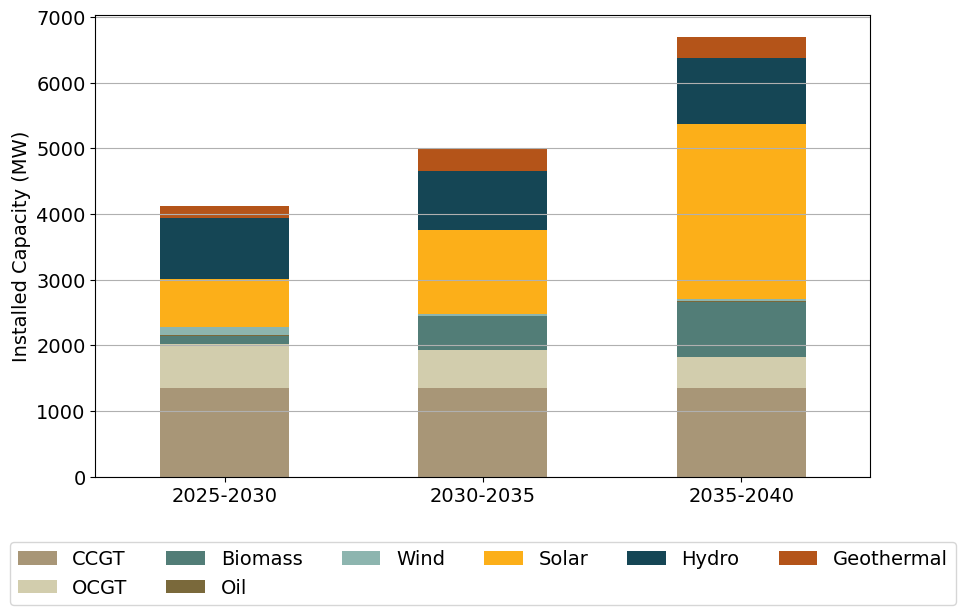

              CCGT   OCGT  Biomass  Oil   Wind    Solar    Hydro  Geothermal
                                                                            
2025-2030 1,343.07 673.02   127.72 8.66 131.40   726.46   935.30      171.00
2030-2035 1,343.07 587.99   512.32 6.46  27.00 1,272.56   904.57      329.89
2035-2040 1,343.07 482.78   840.00 5.18  27.00 2,673.35 1,001.11      329.89


In [188]:
included_rows = [3,4,5]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
print(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap = installed_cap[['CCGT', 'OCGT', 'Biomass', 'Oil', 'Wind', 'Solar', 'Hydro', 'Geothermal']]
installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

print(installed_cap)


           Hydro storage  Hydro ror   OCGT  Biomass     CCGT  Oil     Wind  \
                                                                             
Initial           368.58     363.72 673.02   127.72 1,343.07 8.66   131.40   
2025-2030         368.58     566.72 673.02   127.72 1,343.07 8.66   131.40   
2030-2035         356.15     548.42 587.99   512.32 1,343.07 6.46    27.00   
2035-2040         356.15     644.96 482.78   840.00 1,343.07 5.18    27.00   
2040-2045         356.15     656.45 482.78   840.00 1,343.07 5.18   694.23   
2045-2050         356.15     656.45 482.78   840.00 1,343.07 5.18   694.23   
2050-2055         356.15     656.45 482.78   840.00 1,343.07 5.18   976.60   
2055-2060         356.15     656.45 482.78   840.00 1,343.07 5.18 3,783.78   

              Solar  Geothermal  
                                 
Initial      165.08        0.00  
2025-2030    726.46      171.00  
2030-2035  1,272.56      329.89  
2035-2040  2,673.35      329.89  
2040-2045  5,57

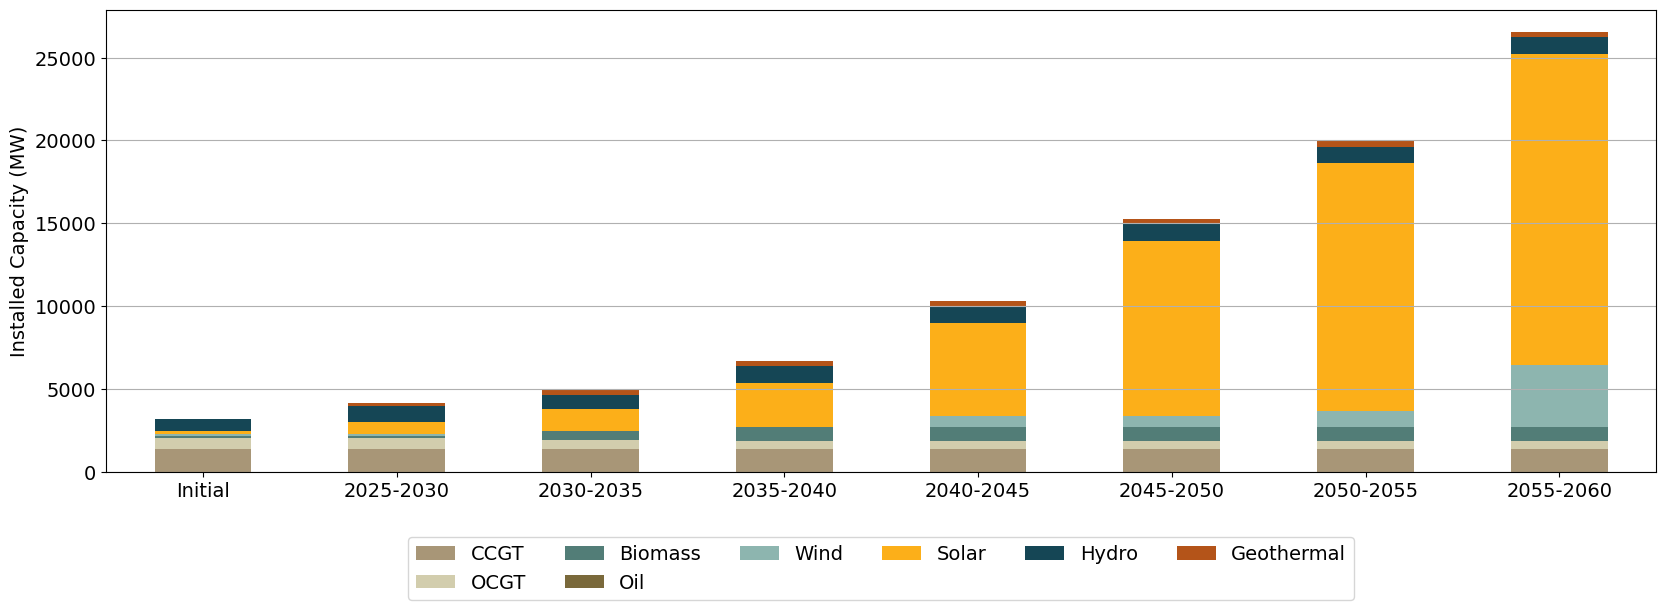

              CCGT   OCGT  Biomass  Oil     Wind     Solar    Hydro  \
                                                                      
Initial   1,343.07 673.02   127.72 8.66   131.40    165.08   732.30   
2025-2030 1,343.07 673.02   127.72 8.66   131.40    726.46   935.30   
2030-2035 1,343.07 587.99   512.32 6.46    27.00  1,272.56   904.57   
2035-2040 1,343.07 482.78   840.00 5.18    27.00  2,673.35 1,001.11   
2040-2045 1,343.07 482.78   840.00 5.18   694.23  5,578.42 1,012.60   
2045-2050 1,343.07 482.78   840.00 5.18   694.23 10,569.73 1,012.60   
2050-2055 1,343.07 482.78   840.00 5.18   976.60 14,961.41 1,012.60   
2055-2060 1,343.07 482.78   840.00 5.18 3,783.78 18,777.23 1,012.60   

           Geothermal  
                       
Initial          0.00  
2025-2030      171.00  
2030-2035      329.89  
2035-2040      329.89  
2040-2045      329.89  
2045-2050      329.89  
2050-2055      329.89  
2055-2060      329.89  


In [190]:

included_rows = [2,3,4,5, 6, 7, 8, 9]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)

for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')

installed_cap = rename_columns(installed_cap)
print(installed_cap)
installed_cap['Hydro'] = installed_cap['Hydro ror'] + installed_cap['Hydro storage']
installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
installed_cap = installed_cap[['CCGT', 'OCGT', 'Biomass', 'Oil', 'Wind', 'Solar', 'Hydro', 'Geothermal']]
installed_cap.plot(kind='bar', stacked=True, figsize=(20, 6), color=get_colors(installed_cap.columns))

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

print(installed_cap)

In [191]:
get_marginal_cost('Gas CCGT', 1)

24.75555555555556

In [192]:
get_marginal_cost('Gas CCGT', 2)

38.37777777777777

In [193]:
get_marginal_cost('Gas OCGT', 3)

64.71428571428572

In [194]:
period_intervals = installed_cap.transpose().columns[1:]
period_intervals

Index(['2025-2030', '2030-2035', '2035-2040', '2040-2045', '2045-2050',
       '2050-2055', '2055-2060'],
      dtype='object', name='')

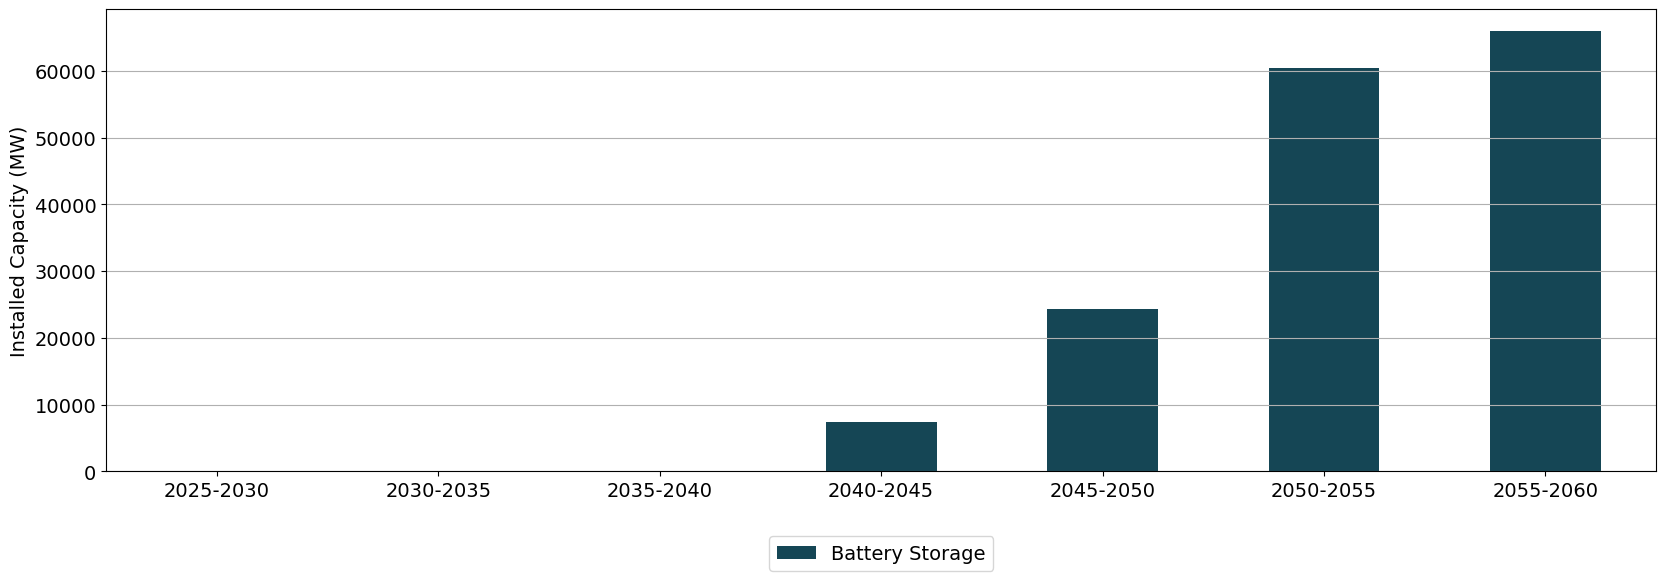

In [195]:
included_rows = [33, 34, 35, 36, 37, 38, 39]
installed_battery = open_csv(file_path, included_rows)
installed_battery.set_index('', inplace=True)

for column in installed_battery.columns:
    installed_battery[column] = pd.to_numeric(installed_battery[column], errors='coerce')

installed_battery.plot(kind='bar', stacked=True, figsize=(20, 6), color=teal2)

# Adding titles and labels
plt.ylabel('Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0, 1.6)
plt.grid(axis='y')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14, labels=['Battery Storage'])
plt.savefig('figures/InstalledCapacity.png', bbox_inches='tight')
plt.show()

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\4133591351.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_installed_cap[technology][1] += total_decom[technology][2]
C:\Users\marih\AppData\Local\Temp\ipykernel_28676\4133591351.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead

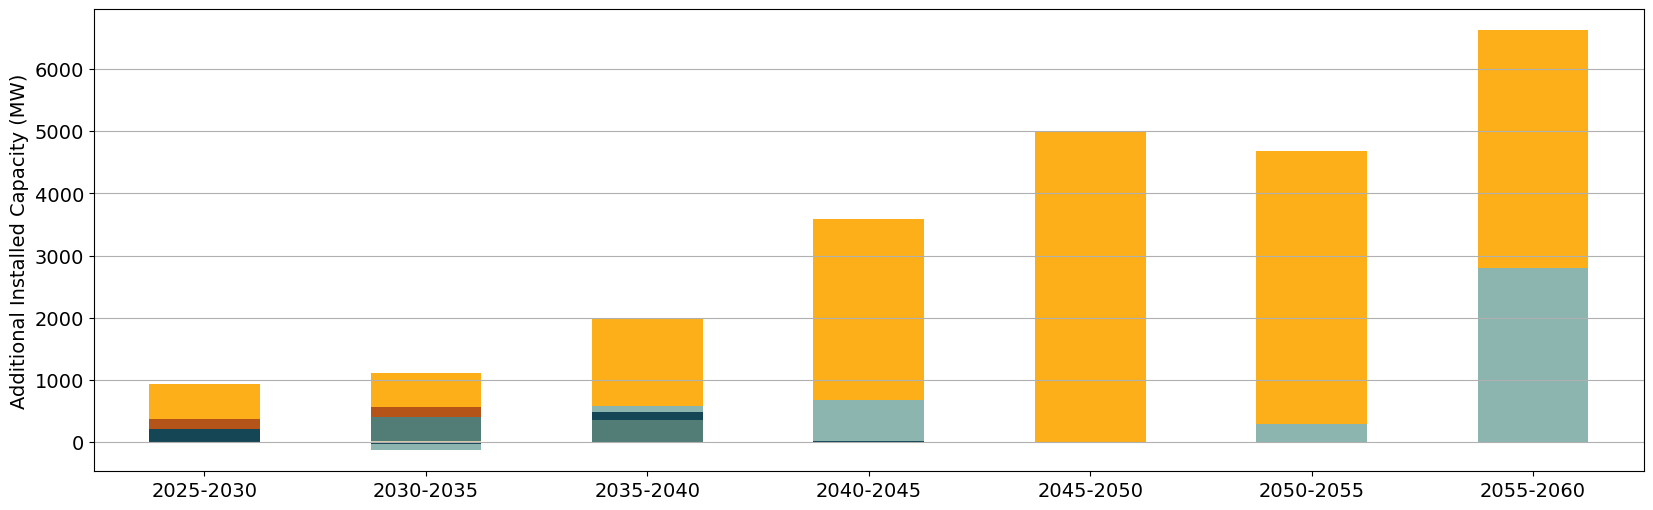

           CCGT   OCGT  Biomass  Hydro  Oil  Geothermal     Wind    Solar
                                                                         
2025-2030  0.00   0.00     0.00 203.00 0.00      171.00     0.00   561.38
2030-2035  0.00  16.63   384.60 -28.18 1.14      158.88  -104.40   546.10
2035-2040  0.00 -20.18   348.68 127.27 0.92        0.00   104.40 1,405.78
2040-2045  0.00   0.00     0.00  11.49 0.00       -0.00   667.23 2,905.07
2045-2050  0.00   0.00     0.00   0.00 0.00       -0.00     0.00 4,991.31
2050-2055  0.00   0.00     0.00   0.00 0.00        0.00   282.37 4,391.68
2055-2060 -0.00  -0.00    -0.00   0.00 0.00        0.00 2,807.18 3,815.82
    OCGT  Hydro  Oil  Solar   Wind  Biomass
1 247.07    NaN  NaN    NaN    NaN      NaN
2 101.66   2.55 3.34    NaN    NaN      NaN
3  85.03  30.73 2.20   5.00 104.40    21.00
CCGT              0.00
OCGT             -3.55
Biomass         733.28
Hydro           313.58
Oil               2.06
Geothermal      329.89
Wind          3,756.

In [196]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap = new_installed_cap[['CCGT', 'OCGT', 'Biomass', 'Hydro', 'Oil', 'Geothermal', 'Wind', 'Solar']]  
 
# total decom needs names with big first letter
total_decom = rename_columns(pd.DataFrame(total_decom))
# Change hydro column name to Hydro
total_decom = total_decom.rename(columns={'hydro': 'Hydro', 'onwind': 'Wind', 'biomass': 'Biomass', 'oil': 'Oil', 'OCGT': 'OCGT', 'solar': 'Solar'})
# Add the ror values in period 3 to the hydro column
# Drop ror column
if 'ror' in total_decom.columns:
    total_decom['Hydro'][3] += total_decom['ror'][3]
    total_decom.drop(columns='ror', inplace=True)
   
# Add the decommissioned capacity to the new installed capacity for period 2 and 3
for technology in new_installed_cap.columns:
    if technology in total_decom:
        # ignore if the technology has no decommissioned capacity, i.e. the value is NaN
        if pd.notna(total_decom[technology][2]):
            new_installed_cap[technology][1] += total_decom[technology][2]
        if pd.notna(total_decom[technology][3]):
            new_installed_cap[technology][2] += total_decom[technology][3]
       
 
 
new_installed_cap.plot(kind='bar', stacked=True, figsize=(20, 6), color=get_colors(new_installed_cap.columns), legend=False)
 
plt.ylabel('Additional Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
#plt.ylim(0, 3000)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()
 
print(new_installed_cap)
print(total_decom)
print(new_installed_cap.transpose().sum(axis=1))

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\3287887595.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_installed_cap[technology][1] += total_decom[technology][2]
C:\Users\marih\AppData\Local\Temp\ipykernel_28676\3287887595.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead

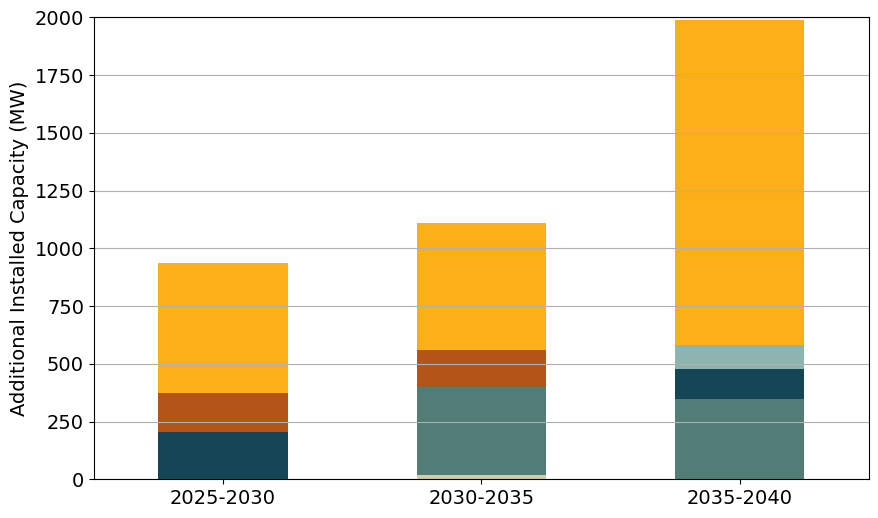

           CCGT   OCGT  Biomass  Hydro  Oil  Geothermal     Wind    Solar
                                                                         
2025-2030  0.00   0.00     0.00 203.00 0.00      171.00     0.00   561.38
2030-2035  0.00  16.63   384.60 -28.18 1.14      158.88  -104.40   546.10
2035-2040  0.00 -20.18   348.68 127.27 0.92        0.00   104.40 1,405.78
2040-2045  0.00   0.00     0.00  11.49 0.00       -0.00   667.23 2,905.07
2045-2050  0.00   0.00     0.00   0.00 0.00       -0.00     0.00 4,991.31
2050-2055  0.00   0.00     0.00   0.00 0.00        0.00   282.37 4,391.68
2055-2060 -0.00  -0.00    -0.00   0.00 0.00        0.00 2,807.18 3,815.82
    OCGT  Hydro  Oil  Solar   Wind  Biomass
1 247.07    NaN  NaN    NaN    NaN      NaN
2 101.66   2.55 3.34    NaN    NaN      NaN
3  85.03  30.73 2.20   5.00 104.40    21.00
CCGT              0.00
OCGT             -3.55
Biomass         733.28
Hydro           313.58
Oil               2.06
Geothermal      329.89
Wind          3,756.

In [213]:
# New installed capacity
new_installed_cap = installed_cap.diff()
new_installed_cap = rename_columns(new_installed_cap)
# new_installed_cap['Hydro'] = new_installed_cap['Hydro ror'] + new_installed_cap['Hydro storage']
# new_installed_cap.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)
new_installed_cap = new_installed_cap.dropna()
new_installed_cap = new_installed_cap[['CCGT', 'OCGT', 'Biomass', 'Hydro', 'Oil', 'Geothermal', 'Wind', 'Solar']]  
 
# total decom needs names with big first letter
total_decom = rename_columns(pd.DataFrame(total_decom))
# Change hydro column name to Hydro
total_decom = total_decom.rename(columns={'hydro': 'Hydro', 'onwind': 'Wind', 'biomass': 'Biomass', 'oil': 'Oil', 'OCGT': 'OCGT', 'solar': 'Solar'})
# Add the ror values in period 3 to the hydro column
# Drop ror column
if 'ror' in total_decom.columns:
    total_decom['Hydro'][3] += total_decom['ror'][3]
    total_decom.drop(columns='ror', inplace=True)
   
# Add the decommissioned capacity to the new installed capacity for period 2 and 3
for technology in new_installed_cap.columns:
    if technology in total_decom:
        # ignore if the technology has no decommissioned capacity, i.e. the value is NaN
        if pd.notna(total_decom[technology][2]):
            new_installed_cap[technology][1] += total_decom[technology][2]
        if pd.notna(total_decom[technology][3]):
            new_installed_cap[technology][2] += total_decom[technology][3]
       
 
 
new_installed_cap.plot(kind='bar', stacked=True, figsize=(10, 6), color=get_colors(new_installed_cap.columns), legend=False)
 
plt.ylabel('Additional Installed Capacity (MW)', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
plt.grid(axis='y')
plt.xlim(-0.5, 2.5)
plt.ylim(0, 2000)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=6, fontsize=14)
plt.savefig('figures/NewInstalledCapacity.png', bbox_inches='tight')
plt.show()
 
print(new_installed_cap)
print(total_decom)
print(new_installed_cap.transpose().sum(axis=1))

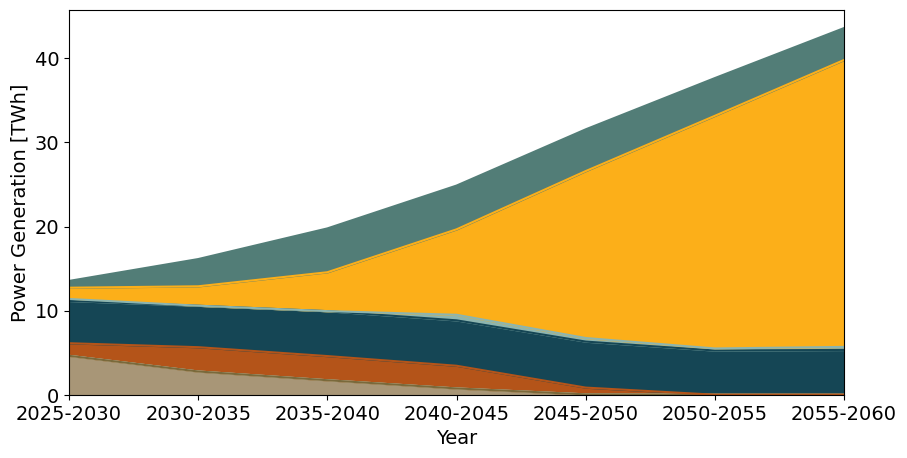

In [197]:
included_rows = [13, 14, 15, 16, 17, 18, 19]

dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')

dispatch = rename_columns(dispatch)

dispatch /= 1000
dispatch['Hydro'] = dispatch['Hydro ror'] + dispatch['Hydro storage']
dispatch.drop(columns=['Hydro ror', 'Hydro storage'], inplace=True)

# reorder columns to ['CCGT',   'OCGT',  'Oil',  'Geothermal' , 'Hydro', 'Wind', 'Solar',   'Biomass']
dispatch = dispatch[['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]

production_plot = dispatch.plot.area(stacked=True, color=get_colors(dispatch.columns),figsize=(10, 5), legend=False)
production_plot.set_xlim(0,6)
plt.ylabel('Power Generation [TWh]', fontsize=14)
plt.xlabel('Year', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)
plt.yticks(fontsize=14)
#plt.ylim(0, 20)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=4, fontsize=14)

plt.savefig('figures/Production.png', bbox_inches='tight')

In [198]:
dispatch.sum()

CCGT           9.90
OCGT           0.01
Oil            0.00
Geothermal    10.76
Hydro         36.75
Wind           1.93
Solar        100.05
Biomass       27.71
dtype: float64

In [199]:
dispatch.transpose().sum()


2025-2030   13.53
2030-2035   16.13
2035-2040   19.78
2040-2045   24.87
2045-2050   31.56
2050-2055   37.65
2055-2060   43.60
dtype: float64

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\1402427248.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


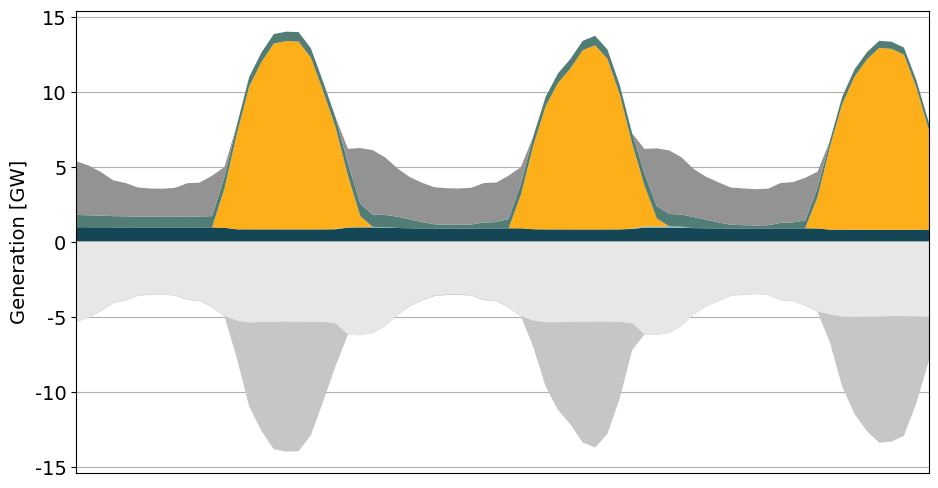

In [200]:
period = '2055-2060'
scenario_number = 'scenario1'
 
filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)
 
# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
snapshots = snapshots[['GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW', 'storDischarge_MW', 'storCharge_MW', 'Load_MW', 'LoadShed_MW']]
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
colors= [beige2, beige3, beige1, brown2, teal2, teal4, yellow, teal3, grey4, red1]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
#plt.xticks(rotation = 0, fontsize=14)
# Remove xticks
plt.xticks([])
plt.yticks(fontsize=14)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
#plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(1, 2*24+22)
#ax.set_ylim(-3250, 3250)
ax.grid(axis='y')
plt.savefig('figures/Dispatch.png', bbox_inches='tight')

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\2112921999.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


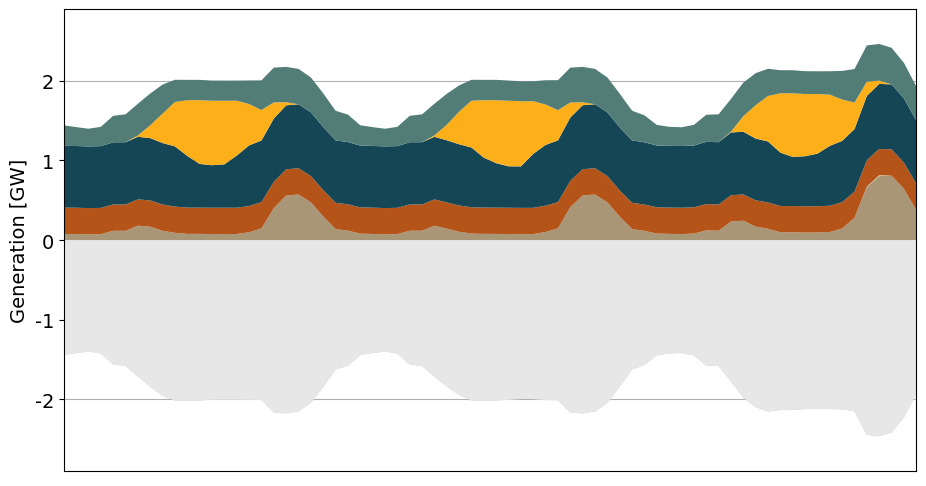

In [201]:
period = '2030-2035'
scenario_number = 'scenario1'
 
filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)
 
# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
snapshots = snapshots[['GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW', 'storDischarge_MW', 'storCharge_MW', 'Load_MW', 'LoadShed_MW']]
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
colors= [beige2, beige3, beige1, brown2, teal2, teal4, yellow, teal3, grey4, red1]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
#plt.xticks(rotation = 0, fontsize=14)
# Remove xticks
plt.xticks([])
plt.yticks(fontsize=14)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
#plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(1, 2*24+22)
#ax.set_ylim(-3250, 3250)
ax.grid(axis='y')
plt.savefig('figures/Dispatch.png', bbox_inches='tight')

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\635275634.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


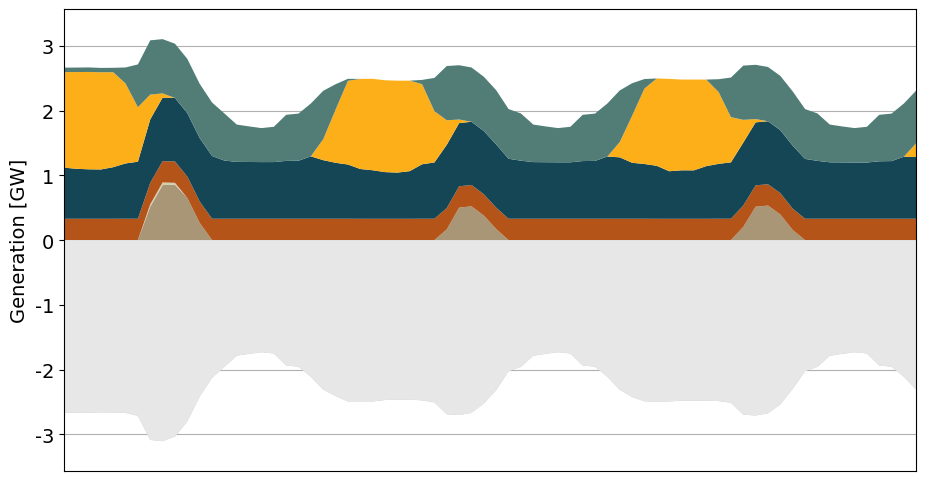

In [202]:
period = '2035-2040'
scenario_number = 'scenario1'
 
filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number)]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('storDischarge_MW')
snapshot_columns.append('storCharge_MW')
snapshot_columns.append('Hour')
snapshot_columns.append('Load_MW')
snapshot_columns.append('LoadShed_MW')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)
 
# Sum based on Hour and then plot aggregated snapshots
snapshots = snapshots.groupby('Hour').sum()
snapshots = snapshots[['GasCCGT_MW', 'GasOCGT_MW', 'Oilexisting_MW', 'Geo_MW', 'Hydrorun-of-the-river_MW', 'Windonshore_MW', 'Solar_MW', 'Bio_MW', 'storDischarge_MW', 'storCharge_MW', 'Load_MW', 'LoadShed_MW']]
fig, ax=plt.subplots(figsize = (11,6))
columns_to_plot = [col for col in snapshots.columns if col not in ['Hour', 'storCharge_MW', 'Load_MW']]
colors= [beige2, beige3, beige1, brown2, teal2, teal4, yellow, teal3, grey4, red1]
dispatch_plot = plt.stackplot(snapshots.index, [snapshots[col] for col in columns_to_plot], colors=colors, zorder=2)
plt.stackplot(snapshots.index, snapshots['storCharge_MW'] + snapshots['Load_MW'], labels=['storCharge_MW'], colors=[grey3], zorder=2)
plt.stackplot(snapshots.index, snapshots['Load_MW'], labels=['Load'], colors=[grey1], zorder=2)
#plt.xticks(rotation = 0, fontsize=14)
# Remove xticks
plt.xticks([])
plt.yticks(fontsize=14)
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
# myFmt = mdates.DateFormatter('%d %b')
# ax.xaxis.set_major_formatter(myFmt)
all_labels = new_names_2 + ['Battery discharge'] +['Load shedding'] + ['Battery charge'] + ['Load']
#plt.legend(labels=all_labels,loc='upper center', bbox_to_anchor=(0.5, -0.06), ncol=6, fontsize=14)
ax.set_ylabel('Generation [GW]', fontsize=14)
ax.set_xlim(1, 2*24+22)
#ax.set_ylim(-3250, 3250)
ax.grid(axis='y')
plt.savefig('figures/Dispatch.png', bbox_inches='tight')

In [203]:
snapshots

,GasCCGT_MW,GasOCGT_MW,Oilexisting_MW,Geo_MW,Hydrorun-of-the-river_MW,Windonshore_MW,Solar_MW,Bio_MW,storDischarge_MW,storCharge_MW,Load_MW,LoadShed_MW
Hour,,,,,,,,,,,,
1,0.35,0.00,0.00,329.89,790.08,0.00,"1,476.57",68.78,0.00,-0.00,"-2,665.67",0.00
2,0.35,0.00,0.00,329.89,772.87,0.00,"1,494.41",69.24,0.00,-0.00,"-2,666.76",0.00
3,0.35,0.00,0.00,329.89,764.20,0.00,"1,504.45",70.25,0.00,-0.00,"-2,669.14",0.00
4,0.35,0.00,0.00,329.89,761.80,0.00,"1,502.49",66.96,0.00,-0.00,"-2,661.49",0.00
5,0.35,0.00,0.00,329.89,797.03,0.00,"1,468.14",67.65,0.00,-0.00,"-2,663.07",0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
716,25.65,0.00,0.00,329.89,674.21,0.00,0.00,840.00,0.00,-0.00,"-1,869.74",0.00
717,8.82,0.00,0.00,329.89,664.08,0.22,0.00,840.00,0.00,-0.00,"-1,843.00",0.00
718,28.88,0.00,0.00,329.89,675.36,0.18,0.00,840.00,0.00,-0.00,"-1,874.31",0.00


In [204]:
dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro ror', 'Hydro storage', 'Wind', 'Solar', 'Biomass']]
dispatch_firstperiod

KeyError: "['Hydro ror', 'Hydro storage'] not in index"

CCGT         34.20
OCGT          0.00
Oil           0.00
Geothermal   11.07
Hydro        37.18
Wind          1.70
Solar         9.89
Biomass       5.97
dtype: float64
CCGT         17.12
OCGT          0.01
Oil           0.00
Geothermal   17.91
Hydro        30.55
Wind          0.03
Solar        14.30
Biomass      20.07
dtype: float64
CCGT          0.00
OCGT          0.00
Oil           0.00
Geothermal    0.00
Hydro        12.22
Wind          0.82
Solar        78.25
Biomass       8.71
dtype: float64


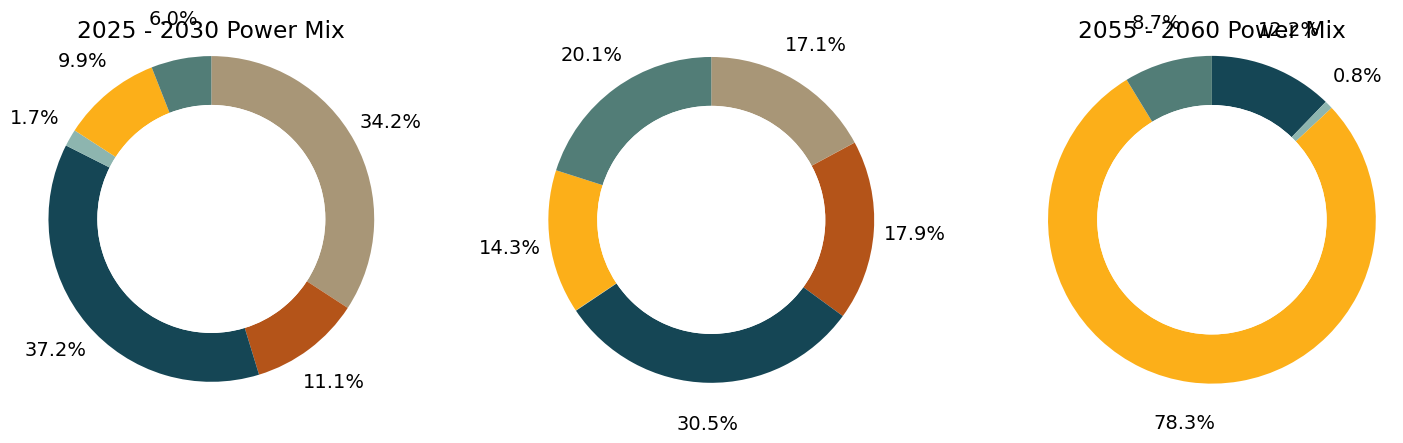

In [ ]:

dispatch_firstperiod = dispatch[:1][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_middleperiod = dispatch[1:2][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
dispatch_lastperiod = dispatch[-1:][['CCGT', 'OCGT', 'Oil', 'Geothermal', 'Hydro', 'Wind', 'Solar', 'Biomass']]
 
plt.rcParams['font.size'] = 14
fig, (ax1, ax15, ax2) = plt.subplots(1, 3, figsize=(15, 5))
 
wedges1, texts1, autotexts1 = ax1.pie(
    dispatch_firstperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_firstperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.25
)

wedges15, texts15, autotexts15 = ax15.pie(
    dispatch_middleperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_middleperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.25
    
)
 
wedges2, texts2, autotexts2 = ax2.pie(
    dispatch_lastperiod.iloc[0].values, autopct=custom_autopct,
    colors=get_colors(dispatch_lastperiod.columns), startangle=90, counterclock=False,
    wedgeprops=dict(width=0.3), pctdistance=1.25
    
)
 
for autotext in autotexts1 + autotexts15 + autotexts2:
    if autotext.get_text() <= '0.3%':
        autotext.set_visible(False)
 
centre_circle1 = plt.Circle((0,0),0.70,fc='white')
ax1.add_artist(centre_circle1)
ax1.set_title("2025 - 2030" +' Power Mix')

centre_circle15 = plt.Circle((0,0),0.70,fc='white')
ax15.add_artist(centre_circle15)
#ax15.set_title("2030 - 2035" +' Power Mix')
 
centre_circle2 = plt.Circle((0,0),0.70,fc='white')
ax2.add_artist(centre_circle2)
ax2.set_title("2055 - 2060" +' Power Mix')
 
ax1.axis('equal')
ax15.axis('equal')
ax2.axis('equal')
 
#fig.legend(dispatch_lastperiod.columns, loc="center right", bbox_to_anchor=(1.05, 0.5))
plt.tight_layout(pad=3.0)

print(dispatch_firstperiod.sum()/dispatch_firstperiod.sum().sum()*100)
print(dispatch_middleperiod.sum()/dispatch_middleperiod.sum().sum()*100)
print(dispatch_lastperiod.sum()/dispatch_lastperiod.sum().sum()*100)



4343.816457635947


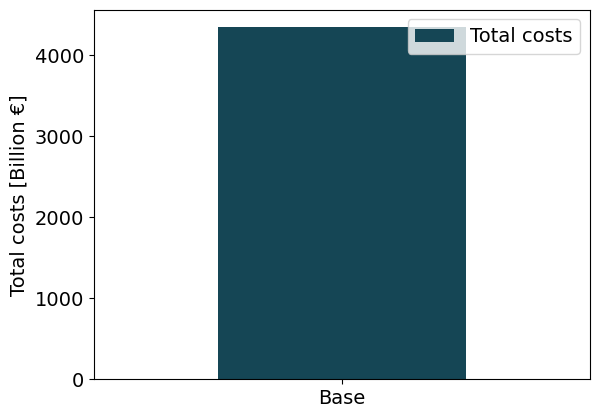

In [ ]:
total_costs = objective_value.iloc[0,1] /1e6
total_costs_df = pd.DataFrame(total_costs, index=['Base'],  columns=['Total costs'])
print(total_costs)
total_costs_df.plot(kind='bar', color=teal2)
plt.ylabel('Total costs [Billion €]', fontsize=14)
plt.xticks(rotation = 0, fontsize=14)

plt.show()

In [ ]:
# Read line capacity data from the transmission data
read_transmission_data = transmission_data[transmission_data['Period'].isin(periods)]

read_transmission_data['LineCapacity'] = transmission_data['transmissionInstalledCap_MW']

line_caps = read_transmission_data[['Period', 'LineCapacity']]

# Filter the data to only include the last period 2035-2040
line_caps_fin = line_caps[line_caps['Period'] == '2035-2040']

# Filter the data to only include the capactiy of the lines
line_caps_fin = line_caps_fin[['LineCapacity']]

# Reset index and start the index from 1 instead of 0
line_caps_fin.reset_index(drop=True, inplace=True)
line_caps_fin.index += 1

# Rename index to Line 
line_caps_fin.index.name = 'Line'

# Drop the LineCapacity name, remove the naming completely
line_caps_fin.columns = ['s_nom_opt']

line_caps_fin

,s_nom_opt
Line,
1,644.40
2,801.72
3,117.00
4,280.62
5,864.27
6,210.36
7,497.25
8,628.65
9,293.40


In [ ]:
# Read line capacity data from the transmission data
read_transmission_data = transmission_data[transmission_data['Period'].isin(periods)]

read_transmission_data['LineCapacity'] = transmission_data['transmissionInstalledCap_MW']

line_caps = read_transmission_data[['Period', 'LineCapacity']]

# Filter the data to only include the last period 2035-2040
line_caps_fin = line_caps[line_caps['Period'] == '2035-2040']

# Filter the data to only include the capactiy of the lines
line_caps_fin = line_caps_fin[['LineCapacity']]

# Reset index and start the index from 1 instead of 0
line_caps_fin.reset_index(drop=True, inplace=True)
line_caps_fin.index += 1

# Rename index to Line 
line_caps_fin.index.name = 'Line'

# Drop the LineCapacity name, remove the naming completely
line_caps_fin.columns = ['s_nom_opt']

line_caps_fin

# Change line_caps_fin to a Series like n.lines.s_nom_opt
line_caps_fin = line_caps_fin.squeeze()

# Change the dtype of the index to string
line_caps_fin.index = line_caps_fin.index.astype(str)


In [ ]:
gen_data = operational_data[(operational_data['Period'] == '2035-2040') & (operational_data['Season'].isin(regular_seasons))]

gen_data = gen_data[['Node', 'Scenario', 'Season', 'AllGen_MW']]
# Change Node names from 'BO00' to 'BO0 0' format
gen_data['Node'] = gen_data['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)



# Sum the AllGen_MW in gen_data for all seasons and hours and then average the sums in all the scenarios for a node
gen_data_summed = gen_data.groupby(['Node', 'Scenario']).sum()

#gen_data_mean = gen_data_summed.groupby('Node').mean()
#gen_data_summed_series = gen_data_summed.squeeze()
#print(gen_data_summed_series)
#print(gen_data_summed_series.sum())


In [ ]:
period = '2030-2035'

gen_data_bus_reg = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(regular_seasons))]
gen_data_bus_reg = gen_data_bus_reg[['Node', 'Scenario', 'AllGen_MW']]
gen_data_bus_reg['Node'] = gen_data_bus_reg['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)
gen_data_bus_reg['AllGen_MW'] = gen_data_bus_reg['AllGen_MW'] * season_scale[0] 
# Multiply gen_data_bus_reg['AllGen_MW'] with the probability of the corresponding scenario
gen_data_bus_reg['AllGen_MW'] = gen_data_bus_reg['AllGen_MW'] * prob_scenarios[gen_data_bus_reg['Scenario'].values[0]]
gen_data_bus_reg = gen_data_bus_reg[['Node', 'AllGen_MW']]
gen_data_bus_reg = gen_data_bus_reg.groupby('Node').sum()

gen_data_bus_reg = gen_data_bus_reg.squeeze()
print(gen_data_bus_reg)
print(gen_data_bus_reg.sum())   


gen_data_bus_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Season'].isin(peak_seasons))]
gen_data_bus_peak = gen_data_bus_peak[['Node', 'Scenario', 'AllGen_MW']]
gen_data_bus_peak['Node'] = gen_data_bus_peak['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)
gen_data_bus_peak['AllGen_MW'] = gen_data_bus_peak['AllGen_MW'] * season_scale[5]
# Multiply gen_data_bus_peak['AllGen_MW'] with the probability of the corresponding scenario
gen_data_bus_peak['AllGen_MW'] = gen_data_bus_peak['AllGen_MW'] * prob_scenarios[gen_data_bus_peak['Scenario'].values[0]]
gen_data_bus_peak = gen_data_bus_peak[['Node', 'AllGen_MW']]
gen_data_bus_peak = gen_data_bus_peak.groupby('Node').sum()

gen_data_bus_peak = gen_data_bus_peak.squeeze()
print(gen_data_bus_peak)
print(gen_data_bus_peak.sum())

gen_data_bus = gen_data_bus_reg + gen_data_bus_peak
print(gen_data_bus)
print(gen_data_bus.sum())

Node
BO0 0      156,375.47
BO0 1          882.95
BO0 10           0.00
BO0 11   4,205,731.31
BO0 12           0.01
BO0 13           0.00
BO0 14   1,826,981.38
BO0 15     984,221.48
BO0 16           0.00
BO0 17           0.00
BO0 18   1,623,458.48
BO0 19           0.01
BO0 2       19,922.70
BO0 20           0.00
BO0 21     250,479.72
BO0 22           0.01
BO0 23     606,676.37
BO0 24       5,594.17
BO0 25     136,144.73
BO0 26           0.00
BO0 27      10,993.26
BO0 28      70,771.10
BO0 29     417,593.22
BO0 3          833.07
BO0 4    3,676,556.86
BO0 5      809,132.36
BO0 6            0.01
BO0 7      268,268.83
BO0 8            0.00
BO0 9      961,365.62
Name: AllGen_MW, dtype: float64
16031983.135114063
Node
BO0 0       559.72
BO0 1       150.40
BO0 10        0.00
BO0 11   28,259.74
BO0 12        0.00
BO0 13        0.00
BO0 14   10,026.37
BO0 15    6,898.46
BO0 16        0.00
BO0 17        0.00
BO0 18   11,152.63
BO0 19        0.00
BO0 2        76.44
BO0 20        0.00
BO0 21    1,5

c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  attrs.loc[bool_b, "default"] = attrs.loc[bool_b].isin({True, "True"})
c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\pypsa\components.py:318: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[

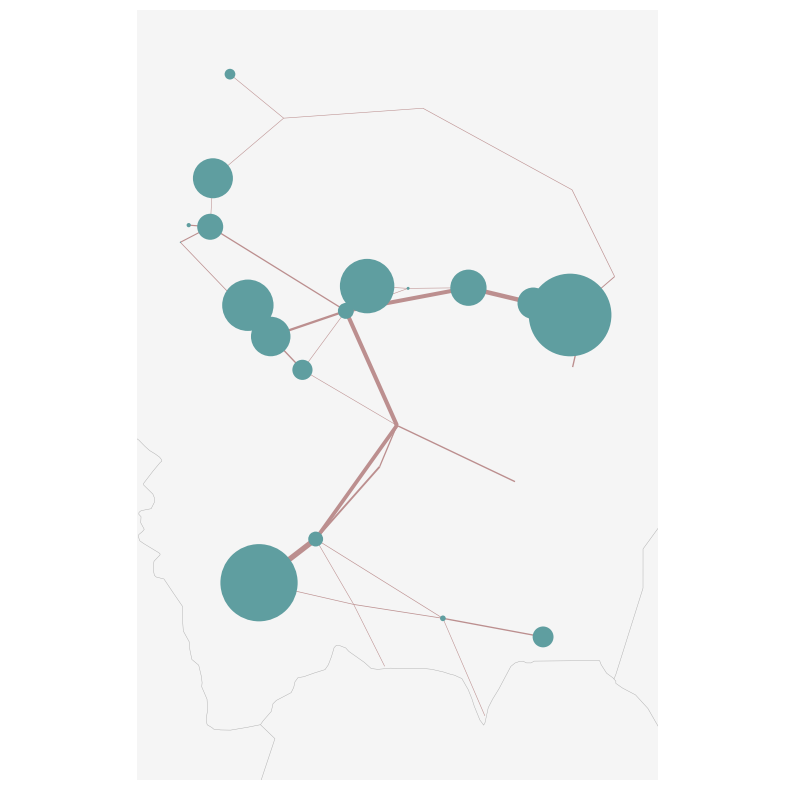

In [ ]:
import pypsa

network_fin = pypsa.Network('C:/Users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/base_30/BVAL_2039.nc')

max_node_size = 0.1  # maximum size of a node for plotting purposes [used in plots]

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n = network_fin


# Sum the power generation for each generator over all timesteps
total_generation = n.generators_t.p.sum()

# Create a DataFrame by merging total generation with bus IDs for each generator
gen_to_bus = pd.DataFrame({'generation': total_generation}).merge(n.generators[['bus']], left_index=True, right_on='Generator')

# Group by 'bus' and sum the generation, resulting in a Series
gen_per_bus = gen_to_bus.groupby('bus')['generation'].sum()


n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=gen_data_bus/15000000,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=line_caps_fin / 3e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [ ]:
technologies_path = 'data_pypsa/technologies.xlsx'

# Load new technologies
new_techs_df = pd.read_excel(technologies_path, sheet_name='technologies_pypsa')
new_technologies = sorted(set(new_techs_df['New_names']))
 
# Map new technology names to old names for lookup
tech_name_map = new_techs_df.set_index('New_names')['Old_names'].to_dict()

# Remove spaces in tech_name_map keys
tech_name_map = {key.replace(" ", ""): value for key, value in tech_name_map.items()}

period = period_intervals[-1]

gen_p_nom = investment_data[(investment_data['Period'] == period) & (investment_data['genInstalledCap_MW'] > 0)]
gen_p_nom = gen_p_nom[['Node', 'GeneratorType', 'genInstalledCap_MW']]

gen_p_nom['Node'] = gen_p_nom['Node'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)

# Change GeneratorType names from EMPIRE names to PyPSA names using tech_name_map
gen_p_nom['GeneratorType'] = gen_p_nom['GeneratorType'].map(tech_name_map)

# Rename the GeneratorType column to carrier and the Node column to bus
gen_p_nom = gen_p_nom.rename(columns={'GeneratorType': 'carrier', 'Node': 'bus'})

# Rename the genInstalledCap_MW column to p_nom and the Generator column to index
gen_p_nom = gen_p_nom.rename(columns={'genInstalledCap_MW': 'p_nom'})

gen_p_nom = gen_p_nom.groupby(['bus', 'carrier']).sum()

gen_p_nom = gen_p_nom.squeeze()

gen_p_nom


bus    carrier
BO0 0  OCGT       39.16
       hydro     120.00
       onwind      0.00
       ror         7.54
       solar       0.00
                  ...  
BO0 8  oil         2.15
       onwind      0.00
       solar       0.00
BO0 9  onwind      0.00
       solar     690.67
Name: p_nom, Length: 90, dtype: float64

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\458297576.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  n.carriers.color['geothermal'] = brown2
C:\Users\marih\AppData\Local\Temp\ipykernel_28676\458297576.py:22: SettingWithCopyWarnin

bus    carrier
BO0 0  OCGT       39.16
       hydro     120.00
       onwind      0.00
       ror         7.54
       solar       0.00
                  ...  
BO0 8  oil         2.15
       onwind      0.00
       solar       0.00
BO0 9  onwind      0.00
       solar     690.67
Name: p_nom, Length: 90, dtype: float64


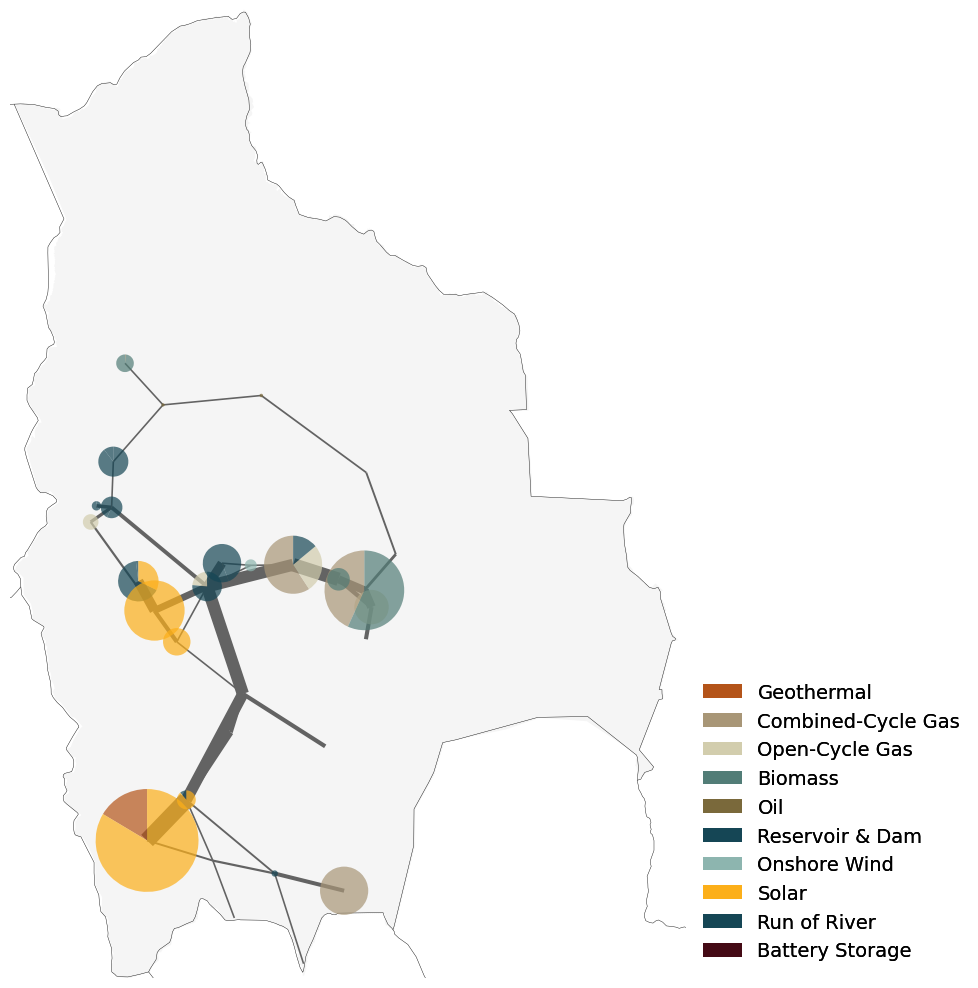

In [ ]:
bus_scale = 3e3 
line_scale = 1e2

import pypsa
import geopandas as gpd
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import numpy as np


regions_onshore = gpd.read_file("c:/users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/resources/shapes/country_shapes.geojson")

# Remove the PHS and load row in n-carriers
if 'PHS' in n.carriers.index:
    n.carriers = n.carriers.drop(index='PHS')
if 'Load' in n.carriers.index:
    n.carriers = n.carriers.drop(index='Load')
n.carriers.color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]
n.carriers.color['geothermal'] = brown2
n.carriers.color['ror'] = teal2
n.carriers.color['hydro'] = teal2
n.carriers.color['battery'] = brown
n.carriers.color['CCGT'] = beige2
n.carriers.color['OCGT'] = beige3
n.carriers.color['oil'] = beige1
n.carriers.color['onwind'] = teal4
n.carriers.color['solar'] = yellow
n.carriers.color['biomass'] = teal3
n.carriers

fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
# gen = n.generators
# gen = gen[~gen['carrier'].str.contains('load')]
# gen = gen.groupby(["bus", "carrier"]).p_nom.sum()

# sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = gen_p_nom #pd.concat([gen, sto])

print(buses)

bus_sizes = buses / bus_scale

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_colors=n.carriers.color,
        bus_alpha=0.7,
        line_widths=line_caps_fin / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors='#636363'	,
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 5, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1250]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW


# add_legend_circles(
#     ax,
#     [s / bus_scale for s in bus_sizes],
#     [f"{s} MW" for s in bus_sizes],
#     legend_kw=legend_circles_dict,    
# )
# add_legend_lines(
#     ax,
#     [s / line_scale for s in line_sizes],
#     [f"{s} MW" for s in line_sizes],
#     legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
# )
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)


fig.tight_layout()





In [ ]:
# Read the load from the excel file Node.xlsx in the sheet ElectricAnnualDemand found in the path 'Data handler/bolivia_v1/Node.xlsx'
load_data = pd.read_excel('Data handler/bolivia_v1/Node.xlsx', sheet_name='ElectricAnnualDemand', skiprows=2)

load_final = load_data[load_data['Period'] == 3]
load_final = load_final[['Nodes', 'ElectricAdjustment in MWh per hour']]
load_final = load_final.rename(columns={'Nodes': 'bus', 'ElectricAdjustment in MWh per hour': 'load'})

# Make load_final into a Series
load_final = load_final.set_index('bus').squeeze()
load_final

bus
BO0 0    2,702,628.29
BO0 1    4,315,033.09
BO0 2      518,955.42
BO0 3    2,704,585.62
BO0 4      782,061.30
BO0 5       67,678.74
BO0 6      650,481.68
BO0 7      244,602.65
BO0 8       35,713.71
BO0 9      952,310.84
BO0 10     334,845.49
BO0 11   1,549,259.30
BO0 12     173,054.29
BO0 13     919,046.95
BO0 14       3,519.40
BO0 15     139,829.45
BO0 16      47,324.96
BO0 17      67,859.06
BO0 18      11,777.46
BO0 19     983,282.09
BO0 20      24,183.07
BO0 21     318,109.92
BO0 22           0.00
BO0 23     414,974.59
BO0 24     233,807.23
BO0 25      96,276.29
BO0 26     208,833.36
BO0 27   1,035,400.76
BO0 28      48,056.09
BO0 29      70,484.27
Name: load, dtype: float64

c:\Users\marih\anaconda3\envs\pypsa-earth-20240127\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


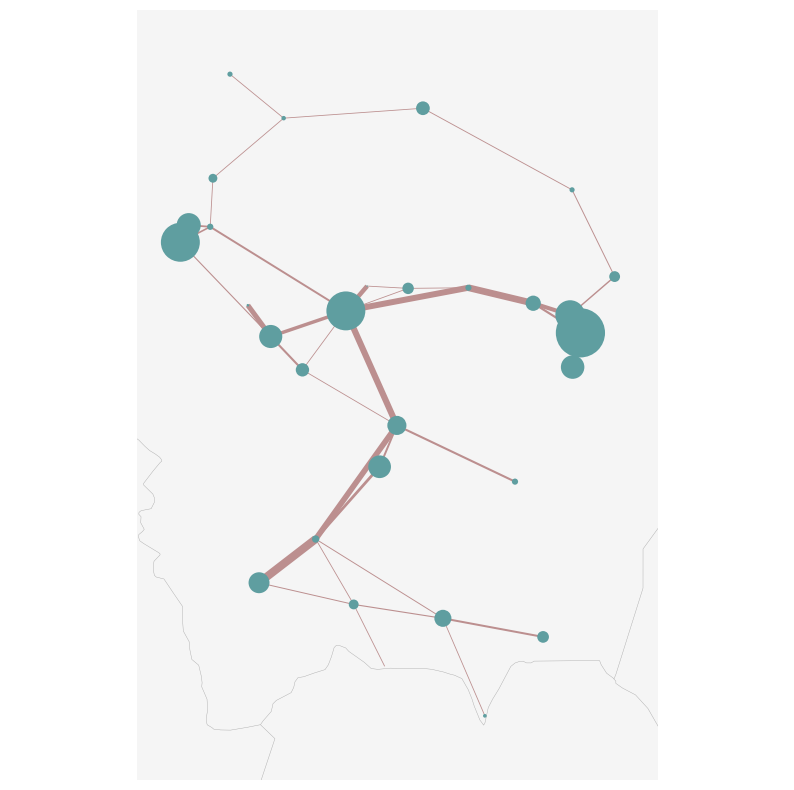

In [ ]:

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

n.plot(
    margin=0.1,
    ax=None,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=1,
    bus_sizes=normalize_node_size(
        load_final
    ),
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=line_caps_fin / 2e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.axis("off")
plt.show()

In [ ]:
legend_circle_sizes = [s / bus_scale for s in bus_sizes]

legend_circle_sizes

[0.016666666666666666,
 0.16666666666666666,
 0.3333333333333333,
 0.4166666666666667]

In [ ]:
# Sum all p_nom values for each bus in buses
buses_sum = buses.groupby('bus').sum()
buses_sum / bus_scale


bus
BO0 0    0.06
BO0 1    0.08
BO0 10   0.00
BO0 11   0.40
BO0 12   0.00
BO0 13   0.00
BO0 14   0.09
BO0 15   0.06
BO0 16   0.00
BO0 17   0.00
BO0 18   0.10
BO0 19   0.00
BO0 2    0.00
BO0 20   0.00
BO0 21   0.05
BO0 22   0.00
BO0 23   0.03
BO0 24   0.01
BO0 25   0.02
BO0 26   0.00
BO0 27   0.01
BO0 28   0.02
BO0 29   0.03
BO0 3    0.02
BO0 4    0.67
BO0 5    0.21
BO0 6    0.00
BO0 7    0.15
BO0 8    0.00
BO0 9    0.23
Name: p_nom, dtype: float64

In [ ]:
bus_scale

3000.0

In [ ]:
if new_run:
    load_shed_cost = node_sheet['NodeLostLoadCost']['C4'].value
    operational_scalar = sum((1+discountrate)**(-j) for j in list(range(0,LeapYearsInvestment)))
    opex_dict = {}
    opex_by_type = []
    for period, num_period in zip(periods, range(1, len(periods) + 1)):
        sum_opex = 0
        discount_multiplier = 1
        if num_period > 1:
            discount_multiplier = pow(1.0 + discountrate, -LeapYearsInvestment * (num_period - 1))
        for i in range(scenario_int):
            for tech in old_names:
                tech_no_space = tech.replace(" ", "")
                generated = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))][tech_no_space + '_MW'].sum()
                generated_peak = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(peak_seasons))][tech_no_space + '_MW'].sum()
                gen_opex = get_marginal_cost(tech,num_period) * (generated * season_scale[0] + generated_peak * season_scale[5]) * prob_scenarios[f'scenario{i+1}'] * discount_multiplier * operational_scalar
                sum_opex += gen_opex
                opex_by_type.append({'Period': num_period, 'Type': tech, 'Investment':  gen_opex/1e6})
            load_shed_opex = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == f'scenario{i+1}') & (operational_data['Season'].isin(regular_seasons))]['LoadShed_MW'].sum() * load_shed_cost * season_scale[0] * prob_scenarios[f'scenario{i+1}'] * discount_multiplier * operational_scalar
            opex_by_type.append({'Period': num_period, 'Type': 'Load Shedding', 'Investment':  load_shed_opex/1e6})
            sum_opex += load_shed_opex
       
        opex_dict[period] = sum_opex / 1e6 # in billion euro
    opex = pd.DataFrame(list(opex_dict.items()), columns=['Period', 'TotalOperationalCost'])
    opex_by_type_df = pd.DataFrame(opex_by_type)

UnboundLocalError: local variable 'efficiency' referenced before assignment

In [ ]:
# load_shed_opex

In [ ]:
period = '2035-2040'
scenario_number = 'scenario1'
 
filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number) & (operational_data['Season'].isin(regular_seasons))]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('Node')
snapshots = filtered_data[snapshot_columns]
snapshots.loc[:,'Hydrorun-of-the-river_MW'] = snapshots['Hydrorun-of-the-river_MW'] + snapshots['Hydroregulated_MW']
snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)

# Group by 'Node' (now called 'bus') and by tech and sum the values
snapshots = snapshots.groupby('Node').sum()

snapshots['bus'] = snapshots.index

snapshots = snapshots.melt(id_vars='bus', var_name='carrier', value_name='value')

# Mapping of carrier names to match the buses.csv format
carrier_mapping = {
    'GasCCGT_MW': 'CCGT',
    'GasOCGT_MW': 'OCGT',
    'Bio_MW': 'biomass',
    'Oilexisting_MW': 'oil',
    'Windonshore_MW': 'onwind',
    'Solar_MW': 'solar',
    'Hydrorun-of-the-river_MW': 'ror',
    'Geo_MW': 'geothermal'
}

snapshots['carrier'] = snapshots['carrier'].map(carrier_mapping)

# sort the values by bus
snapshots = snapshots.sort_values(by='bus')

#Remove values that are zero
#snapshots = snapshots[snapshots['value'] > 0]

# Change the bus names from 'BO00' to 'BO0 0' format
snapshots['bus'] = snapshots['bus'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)

# Multiply the values with the season scale
snapshots['value'] = snapshots['value'] * season_scale[0]

# Make snapshots into a Series with the index as the bus names 
snapshots_regular = snapshots.set_index(['bus', 'carrier']).squeeze()

snapshots_regular


C:\Users\marih\AppData\Local\Temp\ipykernel_28676\209944742.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots.drop(columns=['Hydroregulated_MW'], inplace=True)


bus    carrier   
BO0 0  CCGT               0.00
       ror          181,027.57
       onwind             0.00
       oil                0.00
       geothermal         0.00
                       ...    
BO0 9  biomass            0.00
       OCGT               0.00
       CCGT               0.00
       ror                0.00
       geothermal         0.00
Name: value, Length: 240, dtype: float64

C:\Users\marih\AppData\Local\Temp\ipykernel_28676\1515010525.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  snapshots_peak.drop(columns=['Hydroregulated_MW'], inplace=True)
C:\Users\marih\AppData\Local\Temp\ipykernel_28676\1515010525.py:94: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead

bus    carrier
BO0 0  OCGT       39.16
       hydro     120.00
       onwind      0.00
       ror         7.54
       solar       0.00
                  ...  
BO0 8  oil         2.15
       onwind      0.00
       solar       0.00
BO0 9  onwind      0.00
       solar     289.56
Name: p_nom, Length: 90, dtype: float64


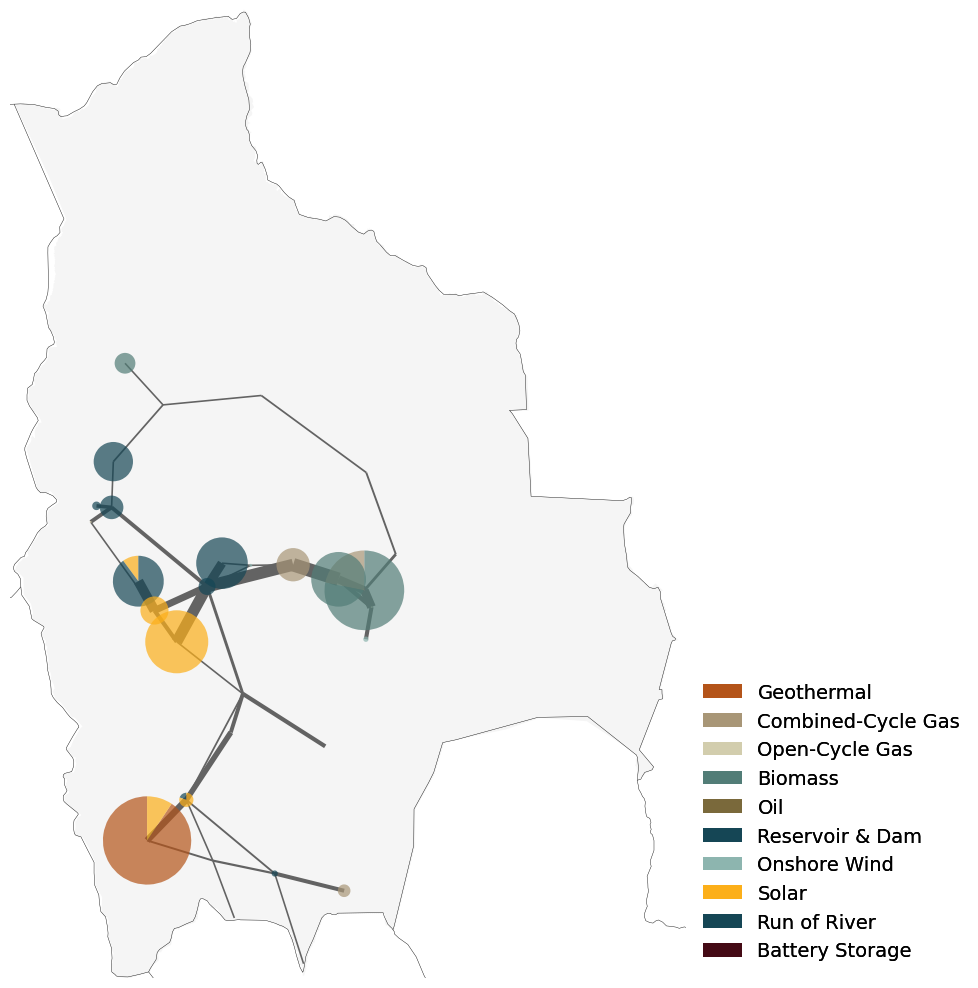

In [ ]:
# Same for peak season

filtered_data = operational_data[(operational_data['Period'] == period) & (operational_data['Scenario'] == scenario_number) & (operational_data['Season'].isin(peak_seasons))]
old_names_no_space = [names.replace(" ", "") for names in old_names]
snapshot_columns = [tech + '_MW' for tech in old_names_no_space]
snapshot_columns.append('Node')
snapshots_peak = filtered_data[snapshot_columns]
snapshots_peak.loc[:,'Hydrorun-of-the-river_MW'] = snapshots_peak['Hydrorun-of-the-river_MW'] + snapshots_peak['Hydroregulated_MW']
snapshots_peak.drop(columns=['Hydroregulated_MW'], inplace=True)

# Group by 'Node' (now called 'bus') and by tech and sum the values
snapshots_peak = snapshots_peak.groupby('Node').sum()

snapshots_peak['bus'] = snapshots_peak.index

snapshots_peak = snapshots_peak.melt(id_vars='bus', var_name='carrier', value_name='value')

# Mapping of carrier names to match the buses.csv format

snapshots_peak['carrier'] = snapshots_peak['carrier'].map(carrier_mapping)

# sort the values by bus
snapshots_peak = snapshots_peak.sort_values(by='bus')

# Change the bus names from 'BO00' to 'BO0 0' format
snapshots_peak['bus'] = snapshots_peak['bus'].str.replace(r'(BO)(\d{1})', r'\1\2 ', regex=True)

# Multiply the values with the season scale
snapshots_peak['value'] = snapshots_peak['value'] * season_scale[5]

# Make snapshots into a Series with the index as the bus names
snapshots_peak = snapshots_peak.set_index(['bus', 'carrier']).squeeze()

# Combine the regular season and peak season snapshots
snapshots_dispatch = snapshots_regular + snapshots_peak

#Remove values that are zero
snapshots_dispatch = snapshots_dispatch[snapshots_dispatch > 0]


snapshots_dispatch
# Read line capacity data from the transmission data
read_transmission_data = transmission_data[transmission_data['Period'].isin(periods)]

read_transmission_data['LineCapacity'] = transmission_data['transmissionInstalledCap_MW']

line_caps = read_transmission_data[['Period', 'LineCapacity']]

# Filter the data to only include the last period 2035-2040
line_caps_fin = line_caps[line_caps['Period'] == period]

# Filter the data to only include the capactiy of the lines
line_caps_fin = line_caps_fin[['LineCapacity']]

# Reset index and start the index from 1 instead of 0
line_caps_fin.reset_index(drop=True, inplace=True)
line_caps_fin.index += 1

# Rename index to Line 
line_caps_fin.index.name = 'Line'

# Drop the LineCapacity name, remove the naming completely
line_caps_fin.columns = ['s_nom_opt']

line_caps_fin

# Change line_caps_fin to a Series like n.lines.s_nom_opt
line_caps_fin = line_caps_fin.squeeze()

# Change the dtype of the index to string
line_caps_fin.index = line_caps_fin.index.astype(str)

bus_scale = 3e3 
line_scale = 1e2

import pypsa
import geopandas as gpd
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import numpy as np


regions_onshore = gpd.read_file("c:/users/marih/OneDrive/Documents/pypsa-2802/pypsa-earth/resources/shapes/country_shapes.geojson")

# Remove the PHS and load row in n-carriers
if 'PHS' in n.carriers.index:
    n.carriers = n.carriers.drop(index='PHS')
if 'Load' in n.carriers.index:
    n.carriers = n.carriers.drop(index='Load')
n.carriers.color = [beige3, beige2, teal3, brown2, beige1, teal2, teal4, yellow, teal2, brown]
n.carriers.color['geothermal'] = brown2
n.carriers.color['ror'] = teal2
n.carriers.color['hydro'] = teal2
n.carriers.color['battery'] = brown
n.carriers.color['CCGT'] = beige2
n.carriers.color['OCGT'] = beige3
n.carriers.color['oil'] = beige1
n.carriers.color['onwind'] = teal4
n.carriers.color['solar'] = yellow
n.carriers.color['biomass'] = teal3
n.carriers

fig, ax = plt.subplots(figsize=(10, 15), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
# gen = n.generators
# gen = gen[~gen['carrier'].str.contains('load')]
# gen = gen.groupby(["bus", "carrier"]).p_nom.sum()

# sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = gen_p_nom #pd.concat([gen, sto])

print(buses)

bus_sizes = buses / bus_scale

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=snapshots_dispatch / 1e7,
        bus_colors=n.carriers.color,
        bus_alpha=0.7,
        line_widths=line_caps_fin / line_scale,
        link_widths=n.links.p_nom / line_scale,
        line_colors='#636363'	,
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
# circles legend may requite some fine-tuning
legend_circles_dict = {"bbox_to_anchor": (1, 0.6), "labelspacing": 5, **legend_kwargs}
bus_sizes = [50, 500, 1000, 1250]  # in MW
line_sizes = [100, 500, 1000, 1500]  # in MW


# add_legend_circles(
#     ax,
#     [s / bus_scale for s in bus_sizes],
#     [f"{s} MW" for s in bus_sizes],
#     legend_kw=legend_circles_dict,    
# )
# add_legend_lines(
#     ax,
#     [s / line_scale for s in line_sizes],
#     [f"{s} MW" for s in line_sizes],
#     legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
# )
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)


fig.tight_layout()





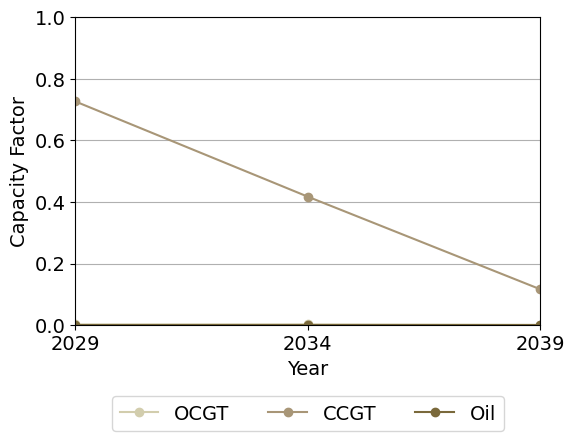

   Period GeneratorType  CapacityFactor
0    2029          OCGT            0.00
1    2034          OCGT            0.00
2    2039          OCGT            0.00
3    2029          CCGT            0.73
4    2034          CCGT            0.42
5    2039          CCGT            0.12
6    2029           Oil            0.00
7    2034           Oil            0.00
8    2039           Oil            0.00


In [ ]:
included_rows = [2,3,4,5]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)
 
for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')
 
installed_cap = rename_columns(installed_cap)
 
included_rows = [9,10,11]
pd.options.display.float_format = '{:,.2f}'.format
 
dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')
 
dispatch = rename_columns(dispatch)
dispatch /= 1000
 
generator_types = ['OCGT', 'CCGT', 'Oil']
period_map = {
'2025-2030': 2029,
'2030-2035': 2034,
'2035-2040': 2039,
}
 
CapacityFactors = []
 
for generator_type in generator_types:
    for period in periods:
        cp = (dispatch[generator_type].loc[period]*1e6)/(8760*installed_cap[generator_type].loc[period])
 
        CapacityFactors.append({'Period': period_map[period], 'GeneratorType': generator_type, 'CapacityFactor': cp})
 
capacity_factors_df = pd.DataFrame(CapacityFactors)
colors = {
    'OCGT': beige3,
    'CCGT': beige2,
    'Oil': beige1
}
 
# Plot the results
plt.figure(figsize=(6, 4))
for generator_type in generator_types:
    df = capacity_factors_df[capacity_factors_df['GeneratorType'] == generator_type]
    plt.plot(df['Period'], df['CapacityFactor'], marker='o', label=generator_type, color=colors[generator_type])
 
 
plt.xlabel('Year')
plt.ylabel('Capacity Factor')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol = 4,fontsize=14)
plt.ylim(0,1.0)
plt.xlim(2029, 2039)
plt.grid(axis='y')
plt.xticks(ticks=[2029,2034,2039])
plt.show()
print(capacity_factors_df)

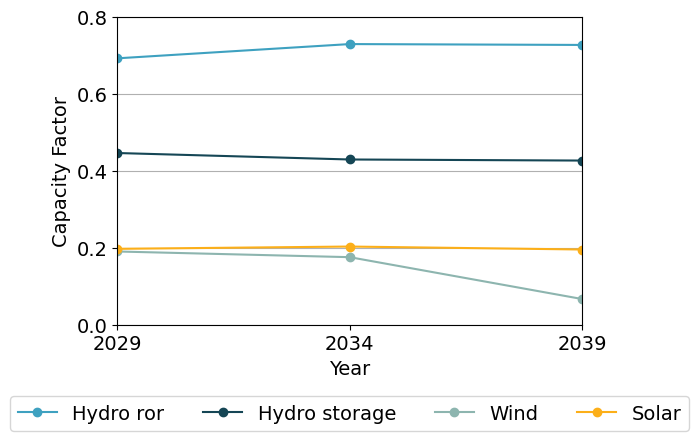

    Period  GeneratorType  CapacityFactor
0     2029      Hydro ror            0.69
1     2034      Hydro ror            0.73
2     2039      Hydro ror            0.73
3     2029  Hydro storage            0.45
4     2034  Hydro storage            0.43
5     2039  Hydro storage            0.43
6     2029           Wind            0.19
7     2034           Wind            0.18
8     2039           Wind            0.07
9     2029          Solar            0.20
10    2034          Solar            0.20
11    2039          Solar            0.20


In [ ]:
included_rows = [2,3,4,5]
installed_cap = open_csv(file_path, included_rows)
installed_cap.set_index('', inplace=True)
 
for column in installed_cap.columns:
    installed_cap[column] = pd.to_numeric(installed_cap[column], errors='coerce')
 
installed_cap = rename_columns(installed_cap)
 
included_rows = [9,10,11]
pd.options.display.float_format = '{:,.2f}'.format
 
dispatch = open_csv(file_path, included_rows)
dispatch.set_index('', inplace=True)
for column in dispatch.columns:
    dispatch[column] = pd.to_numeric(dispatch[column], errors='coerce')
 
dispatch = rename_columns(dispatch)
dispatch /= 1000
 
generator_types = ['Hydro ror', 'Hydro storage', 'Wind', 'Solar']
period_map = {
'2025-2030': 2029,
'2030-2035': 2034,
'2035-2040': 2039,
}
 
CapacityFactors = []
 
for generator_type in generator_types:
    for period in periods:
        cp = (dispatch[generator_type].loc[period]*1e6)/(8760*installed_cap[generator_type].loc[period])
 
        CapacityFactors.append({'Period': period_map[period], 'GeneratorType': generator_type, 'CapacityFactor': cp})
 
capacity_factors_df = pd.DataFrame(CapacityFactors)
colors = {
    'Solar': yellow,
    'Wind': teal4,
    'Hydro ror': blue1,
    'Hydro storage': teal2
}
 
# Plot the results
plt.figure(figsize=(6, 4))
for generator_type in generator_types:
    df = capacity_factors_df[capacity_factors_df['GeneratorType'] == generator_type]
    plt.plot(df['Period'], df['CapacityFactor'], marker='o', label=generator_type, color=colors[generator_type])
 
 
plt.xlabel('Year')
plt.ylabel('Capacity Factor')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol = 4,fontsize=14)
plt.ylim(0,0.8)
plt.xlim(2029, 2039)
plt.grid(axis='y')
plt.xticks(ticks=[2029,2034,2039])
plt.show()
print(capacity_factors_df)